In [1]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read in and prepare the data
data_name = 'ionosphere'
save_figs = False


data   = pd.read_csv('../datasets/' + data_name + '.csv', sep = ',')
x, y   = dataprep(data, scale = None)
n, d   = x.shape
n_classes = len(y.unique())

x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

n_test = x_test.shape[0]

In [3]:
# Random forest on all data for PHATE embedding visualization
rfphate = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42)
rfphate.fit(x, y)
prox_phate = rfphate.get_proximities()

In [4]:
# Random forest for uncertainty measures; using split datasets
rf = RFGAP(oob_score = True, random_state = 42)
rf.fit(x_train, y_train)
prox = rf.get_proximities()

In [5]:
# Generate OOB and Test trust scores
trust_scores_oob = rf.get_trust_scores()
trust_scores_test = rf.get_test_trust(x_test)

In [6]:
def reverse_scale_sklearn(x, min_size = 5, max_size = 100):
    scaler = MinMaxScaler(feature_range = (min_size, max_size))

    return max_size - scaler.fit_transform(x) + min_size

In [7]:
# Helper functions for plots
def reverse_scale(x, min_size = 5, max_size = 100, log_scale = False):
    
    if log_scale:
        x = np.log(x + np.finfo(np.float64).eps)
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size
    else:
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size

    return x_scaled

In [8]:
# RF-PHATE embedding for scatterplots
phate_op = PHATE(knn_dist = 'precomputed', verbose = 0)
emb = phate_op.fit_transform(prox_phate)

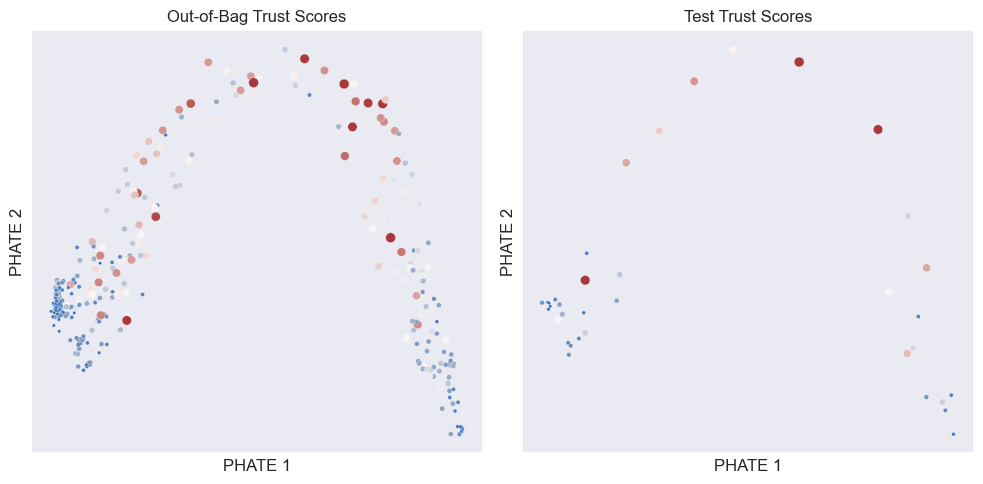

In [9]:
# RF-PHATE train/test plots
sns.set_theme()
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)
color_palette = sns.color_palette('vlag', as_cmap = True)


min_size = 5
max_size = 50

hue_norm = (min_size, max_size)

oob_scale = reverse_scale(trust_scores_oob, min_size = min_size, max_size = max_size)
test_scale = reverse_scale(trust_scores_test, min_size = min_size, max_size = max_size)

sns.scatterplot(ax = axes[0], x = emb[inds_train, 0], y = emb[inds_train, 1],
                hue = oob_scale, 
                hue_norm = hue_norm,
                size = oob_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1],
                hue = test_scale, 
                hue_norm = hue_norm,
                size = test_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


axes[0].set_title('Out-of-Bag Trust Scores')
axes[1].set_title('Test Trust Scores')

for ax in axes:
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend([], [], frameon = False)


plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_trust_scores_oob_test.pdf')

In [10]:
# Get trust score quantiles for both OOB and Test points
oob_trust_quantiles = rf.trust_quantiles
test_trust_quantiles = rf.trust_quantiles_test

In [11]:
# The number of points dropped based on low trust quantiles
n_oob_dropped = []
n_test_dropped = []

for q in oob_trust_quantiles:
    n_oob_dropped.append(np.sum(trust_scores_oob < q))
n_oob_dropped = np.array(n_oob_dropped)

for q in oob_trust_quantiles:
    n_test_dropped.append(np.sum(trust_scores_test < q))
n_test_dropped = np.array(n_test_dropped)

In [12]:
def nearest_value_index(arr, value):
    return np.argmin(np.abs(arr - value))

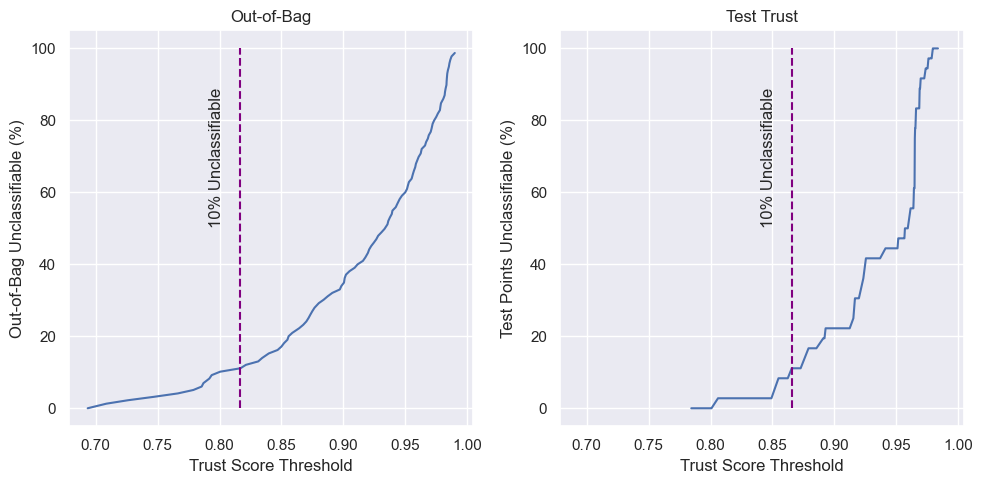

In [13]:
# Plot of test  and oob trust score quantiles
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharex=True)


sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = n_oob_dropped / len(y_train) * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = n_test_dropped / len(y_test) * 100)

# Vertical Lines
axes[0].vlines(x = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = 0, ymax = 100)

axes[0].text(oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)] - 0.025, 50, '10% Unclassifiable', rotation=90, verticalalignment='bottom')

axes[1].vlines(x = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = 0, ymax = 100)

axes[1].text(test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)] - 0.025, 50, '10% Unclassifiable', rotation=90, verticalalignment='bottom')

axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Out-of-Bag Unclassifiable (%)')
axes[0].set_xlabel('Trust Score Threshold')

axes[1].set_title('Test Trust')
axes[1].set_ylabel('Test Points Unclassifiable (%)')
axes[1].set_xlabel('Trust Score Threshold')

plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_pct_dropped.pdf')

In [14]:
# Check accuracy after dropping unclassifiable points
oob_drop_accuracy = []
test_drop_accuracy = []

oob_prop_misclass_dropped = []
test_prop_misclass_dropped = []

for q in oob_trust_quantiles:

    idx_temp = trust_scores_oob >= q
    idx_temp_test = trust_scores_test >= q

    oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[idx_temp]
    dropped_oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[~idx_temp]

    oob_drop_accuracy.append(np.mean(y_train[idx_temp] == oob_preds))

    try:
        test_drop_accuracy.append(np.mean(y_test[idx_temp_test] == rf.predict(x_test[idx_temp_test])))

    except:
        test_drop_accuracy.append(1)

    # Add proportion of misclassified points dropped

    oob_prop_misclass_dropped.append(np.mean(y_train[~idx_temp] != dropped_oob_preds))

    try:
        test_prop_misclass_dropped.append(np.mean(y_test[~idx_temp_test] != rf.predict(x_test[~idx_temp_test])))
    except:
        test_prop_misclass_dropped.append(0) # CHECK TO SEE IF THIS MAKES SENSE



oob_drop_accuracy = np.array(oob_drop_accuracy)
test_drop_accuracy = np.array(test_drop_accuracy)

oob_prop_misclass_dropped = np.array(oob_prop_misclass_dropped)
test_prop_misclass_dropped = np.array(test_prop_misclass_dropped)

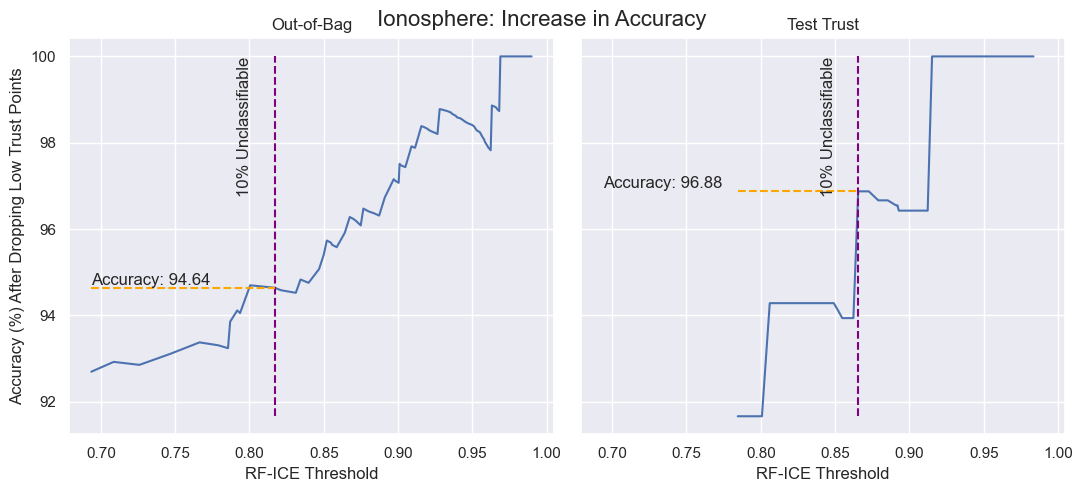

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5), sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)

sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = oob_drop_accuracy * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = test_drop_accuracy * 100)


axes[0].vlines(x = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = np.min((oob_drop_accuracy, test_drop_accuracy)) * 100, ymax = 100)

axes[1].vlines(x = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = np.min((oob_drop_accuracy, test_drop_accuracy)) * 100, ymax = 100)

axes[0].text(oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)] - 0.025, 100, '10% Unclassifiable', rotation=90, verticalalignment='top')
axes[1].text(test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)] - 0.025, 100, '10% Unclassifiable', rotation=90, verticalalignment='top')

# Horizontal Lines
x_value = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)]
y_value = np.interp(x_value, oob_trust_quantiles, oob_drop_accuracy * 100)
axes[0].hlines(y = y_value, xmin = np.min(oob_trust_quantiles), xmax = x_value, color = 'orange', linestyle = '--')
axes[0].text(np.min(oob_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')

x_value = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)]
y_value = np.interp(x_value, test_trust_quantiles, test_drop_accuracy * 100)
axes[1].hlines(y = y_value, xmin = np.min(test_trust_quantiles), xmax = x_value, color = 'orange', linestyle = '--')
axes[1].text(np.min(test_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')


# General plot updates
axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Accuracy (%) After Dropping Low Trust Points')
axes[0].set_xlabel('RF-ICE Threshold')

axes[1].set_title('Test Trust')
axes[1].set_xlabel('RF-ICE Threshold')

plt.tight_layout()
fig.suptitle(str.title(data_name) + ': Increase in Accuracy', fontsize=16)
if save_figs:
    plt.savefig('./figures/' + data_name + '_accuracy_after_dropped.pdf')

In [18]:
rffull = RFGAP(oob_score = True, random_state = 42)
rffull.fit(x, y)
full_trust_scores = rffull.get_trust_scores()

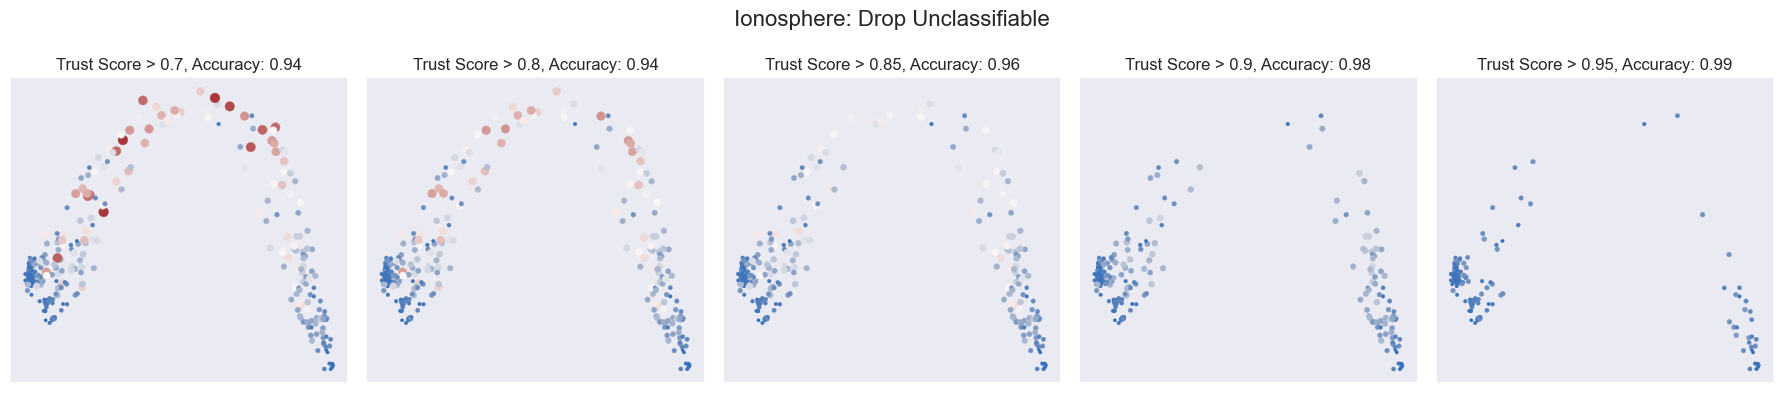

In [19]:
qs = [0.7, 0.8, 0.85, 0.9, 0.95]

fig, axes = plt.subplots(1, 5, figsize = (18, 4), sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.025)
color_palette = sns.color_palette('vlag', as_cmap = True)

# Define size and colormap outside the loop
size = reverse_scale(full_trust_scores)
colormap = reverse_scale(full_trust_scores)
hue_norm = (int(np.min(colormap)), int(np.quantile(colormap, 0.99)))

for i, ax in enumerate(axes.ravel()):

    q = qs[i]
    idx_temp = full_trust_scores > q
    oob_preds = np.argmax(rffull.oob_decision_function_, axis = 1)[idx_temp]

    sns.scatterplot(ax = ax, x = emb[idx_temp, 0], y = emb[idx_temp, 1],
                    hue = colormap[idx_temp],
                    hue_norm = hue_norm,
                    size = size[idx_temp],
                    sizes = (5, 50),
                    size_norm = hue_norm,
                    palette = color_palette,
                    legend = False,
                    edgecolor = None)  # Disable legend for each subplot
    
    ax.set_title(f'Trust Score > {q}, Accuracy: {np.mean(y[idx_temp] == oob_preds):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])   

fig.suptitle(str.title(data_name) + ': Drop Unclassifiable', fontsize=16)

plt.tight_layout()
if save_figs:
    plt.savefig('./figures/' + data_name + '_trust_scores_sequence.pdf')

In [22]:
thresholds_table = np.linspace(0.05, 0.95, int(0.95 / 0.05))

[0.05       0.10294118 0.15588235 0.20882353 0.26176471 0.31470588
 0.36764706 0.42058824 0.47352941 0.52647059 0.57941176 0.63235294
 0.68529412 0.73823529 0.79117647 0.84411765 0.89705882 0.95      ]


In [ ]:
# Table of results
quantiles_table = np.round(np.linspace(0.05, .95, 19), 2)
# oob_trust_quantiles_table = np.quantile(trust_scores_oob, quantiles_table)
dataset_name_table = np.repeat(data_name, len(quantiles_table))
trust_table = oob_trust_quantiles[[int(quantile * 100) for quantile in quantiles_table]]
oob_drop_accuracy_table = oob_drop_accuracy[[int(quantile * 100) for quantile in quantiles_table]] # This is not correct! These are the quantiles, not thresholds!!
n_oob_dropped_table = n_oob_dropped[[int(quantile * 100) for quantile in quantiles_table]]
oob_accuracy_table = np.repeat(rf.oob_score_, len(quantiles_table))
accuracy_diff_table = oob_drop_accuracy_table - oob_accuracy_table
accuracy_drop_ratio = (accuracy_diff_table) / (n_oob_dropped_table / n)

# Headers

headers = ['Dataset', 'Quantiles', 'Trust', 'Baseline Accuracy', 
           'Classifiable Accuracy','Accuracy Diff', 'Pct. Dropped',
           'Accuracy Drop Ratio']

table = pd.DataFrame(np.vstack([dataset_name_table, quantiles_table, trust_table,
                                oob_accuracy_table, oob_drop_accuracy_table,
                                  accuracy_diff_table, n_oob_dropped_table / n,
                                    accuracy_drop_ratio]).T, columns = headers)


if save_figs:
    table.to_csv('./trust_tables/' + data_name + '_trust_table.csv', index = False)